# Noisy-Clustering

In [1]:
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
import tensorflow as tf
import tensorflow_hub as tfhub
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

In [2]:
txt_dir = "../datasets/cleaned_datasets/clean_dataset" 

## Reading Data into DataFrame

In [3]:
def read_data(_dir:str) -> pd.DataFrame:
    data = {}
    data["url"] = []
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.abspath(os.path.join(root, _dir, txt_file))
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                data["url"].append(file_name)
                data["text"].append(txt)
                data["class"].append(class_name)
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [4]:
%%time
df = read_data(txt_dir)

CPU times: user 625 ms, sys: 735 ms, total: 1.36 s
Wall time: 2.4 s


In [5]:
df.head()

,url,text,class
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction


## Get the Embeddings

In [6]:
model_url = "./DAN/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/"

In [7]:
%%time
model = tfhub.Module(model_url)

CPU times: user 1.69 s, sys: 120 ms, total: 1.81 s
Wall time: 1.82 s


In [8]:
sess = tf.InteractiveSession()

In [9]:
sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

[None, None]

In [10]:
%%time
embeddings = sess.run(model(list(df["text"])))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 11.1 s, sys: 1.41 s, total: 12.6 s
Wall time: 11.5 s


In [11]:
sess.close()

In [12]:
print(df.shape)
print(embeddings.shape)

(10306, 3)
(10306, 512)


In [13]:
embeddings[0].reshape(1,-1).shape

(1, 512)

In [14]:
df["embedding"] = [np.squeeze(x.reshape(1,-1)) for x in embeddings]

In [15]:
df.head()

,url,text,class,embedding
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction,"[0.02091142, -0.042140108, -0.008535606, 0.006..."
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction,"[-0.022017265, -0.040350087, -0.013414536, -0...."
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction,"[0.0024706149, -0.06767778, -0.006135382, -0.0..."
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction,"[-0.012890103, 0.036593255, -0.0019980855, -0...."
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction,"[0.029195484, -0.0001973573, -0.035709944, -0...."


## Dimensionality Reduction

### 3D PCA

In [16]:
pca = PCA(n_components=3)

In [17]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [18]:
matrix = pca.fit_transform(embeddings_lst)

In [19]:
matrix.shape

(10306, 3)

In [20]:
df["x"] = matrix[:,0]
df["y"] = matrix[:,1]
df["z"] = matrix[:,2]

### 2D PCA

In [21]:
pca = PCA(n_components=2)

In [22]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [23]:
matrix = pca.fit_transform(embeddings_lst)

In [24]:
df["a"] = matrix[:,0]
df["b"] = matrix[:,1]

In [25]:
df.head()

,url,text,class,embedding,x,y,z,a,b
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,the goal of feature selection in text classifi...,prediction,"[0.02091142, -0.042140108, -0.008535606, 0.006...",-0.060099,0.140115,0.214279,-0.060099,0.140111
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,conclusion a major assumption of regression or...,prediction,"[-0.022017265, -0.040350087, -0.013414536, -0....",0.208038,0.044545,-0.011713,0.208038,0.044545
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,in category as a supervised machine process is...,prediction,"[0.0024706149, -0.06767778, -0.006135382, -0.0...",-0.076284,0.027441,0.402089,-0.076284,0.027440
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,the pls regression is used to connect the depe...,prediction,"[-0.012890103, 0.036593255, -0.0019980855, -0....",0.235622,-0.172961,-0.070759,0.235624,-0.172960
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,pace regression the basic idea of regression a...,prediction,"[0.029195484, -0.0001973573, -0.035709944, -0....",0.270747,0.025772,-0.249921,0.270745,0.025772


## Visualization

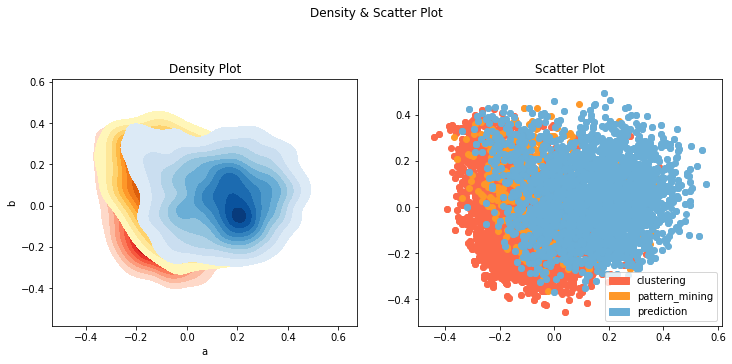

In [26]:
import matplotlib.patches as mpatches


cmaps = cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "purple", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,10))
fig.suptitle("Density & Scatter Plot")

ax_1 = fig.add_subplot(2,2,1)
ax_2 = fig.add_subplot(2,2,2)

ax_1.set_title("Density Plot")
ax_2.set_title("Scatter Plot")


labels = []
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = ax_1)
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    ax_2.scatter(group.a, group.b, color = color_from_cmap)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels)


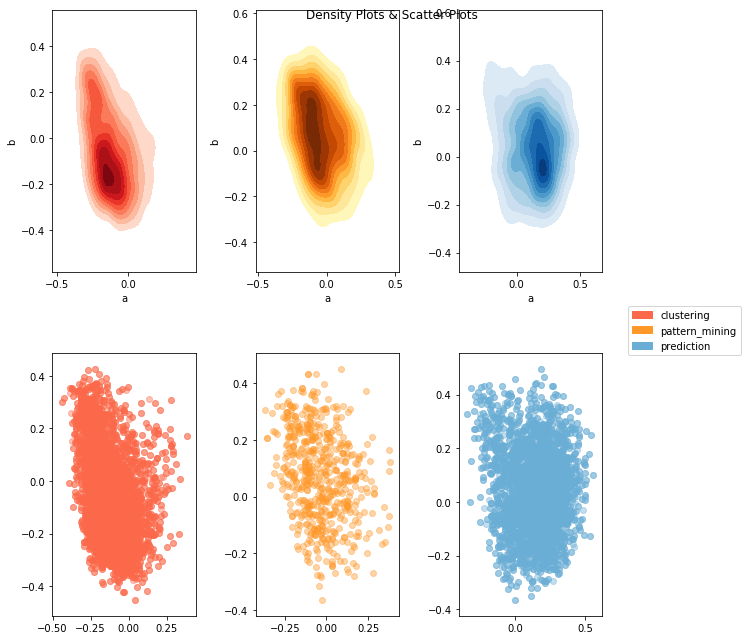

In [27]:
#%matplotlib inline
import matplotlib.patches as mpatches


cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "yellow", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(11,9))
fig.suptitle("Density Plots & Scatter Plots")

ax_1 = fig.add_subplot(2,3,1)
ax_2 = fig.add_subplot(2,3,2)
ax_3 = fig.add_subplot(2,3,3)

ax_4 = fig.add_subplot(2,3,4)
ax_5 = fig.add_subplot(2,3,5)
ax_6 = fig.add_subplot(2,3,6)

labels = []
axis = [ax_1, ax_2, ax_3]
axis_scatter = [ax_4, ax_5, ax_6]
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = axis[counter])
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    axis_scatter[counter].scatter(group.a, group.b, color = color_from_cmap, alpha = 0.4)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels, bbox_to_anchor=(2, 1.2))
fig.tight_layout()

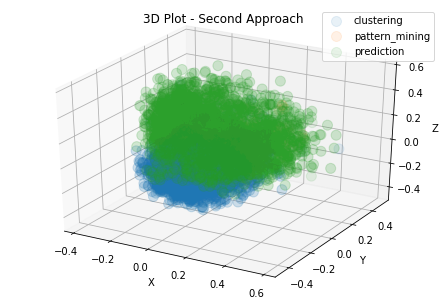

In [28]:
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
fig.suptitle("3D Plot - Second Approach")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

groups = df.groupby("class")
for name, group in groups:
    
    ax.scatter(group.z, group.y, group.x, s = 100, label=name, alpha = 0.1)
   
    ax.legend()


## Calculate Homogenity/Variance of an Cluster 

In [29]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import DBSCAN

In [30]:
clusters = df.groupby("class")

In [31]:
#[x.reshape(1,-1) for x in df["embedding"]]

In [32]:
for _class, data in clusters: 
    embeddings = [x for x in df["embedding"]]
    print("{} variance: {}".format(_class,np.var(np.array(embeddings))))

clustering variance: 0.0019504626980051398
pattern_mining variance: 0.0019504626980051398
prediction variance: 0.0019504626980051398


## Clustering

In [33]:
len(df["embedding"].tolist())

10306

In [34]:
%%time
model_clustering = DBSCAN(eps = 0.45, metric = "cosine" ,min_samples = 4, n_jobs = -1)
#model_prediction = DBSCAN(eps = 0.3, metric = "cosine",min_samples = 7, n_jobs = -1)
model_pattern_mining = DBSCAN(eps = 0.3, metric = "cosine",min_samples = 6, n_jobs = -1)
#model_prediction = DBSCAN(eps = 0.3, metric = "cosine",min_samples = 9, n_jobs = -1)
model_prediction = DBSCAN(eps = 0.4, min_samples = 3, metric = "cosine",  n_jobs = -1)

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 19.8 µs


In [35]:
models = [model_clustering, model_pattern_mining, model_prediction]

In [36]:
%%time
x = 0
outlier_dataframes = {}
df_groups = {}
for _class, group in clusters:
    models[x].fit(group["embedding"].tolist())
    clusters = Counter(models[x].labels_)
    print("{}:{}".format(_class,clusters))
    outlier_dataframes[_class] = group[models[x].labels_==-1]
    
    _df = pd.DataFrame(group)
    _df["cluster"] = models[x].labels_
    df_groups[_class] = _df
    print(group[models[x].labels_==-1].shape)
    x += 1 

clustering:Counter({0: 5141, -1: 4})
(4, 10)
pattern_mining:Counter({0: 568, -1: 14})
(14, 10)
prediction:Counter({0: 4561, -1: 18})
(18, 10)
CPU times: user 852 ms, sys: 1.7 s, total: 2.55 s
Wall time: 4.68 s


In [37]:
#df_groups[2][df_groups[2]["cluster"]==6].head(50)

In [38]:
pd.set_option('display.max_colwidth', -1)

In [39]:
# Clustering
outlier_dataframes["clustering"][["class", "text"]].sample(frac=1).head()

,class,text
7725,clustering,this is a reasonable choice since the silence phones carry little information as far as speaker clustering is concerned
5293,clustering,hence facial image clustering is easier than in the case of movies where actors may have unusual expressions different poses or even makeup
6047,clustering,this is a reasonable choice since the silence phones carry little information as far as speaker clustering is concerned
4937,clustering,hence facial image clustering is easier than in the case of movies where actors may have unusual expressions different poses or even makeup


In [40]:
# Pattern Mining
outlier_dataframes["pattern_mining"][["class", "text"]].sample(frac=1).head(20)

,class,text
10273,pattern_mining,applying temporal purchase patterns derived from sequential pattern analysis spa for recommendation services also often makes users unhappy with the inaccurate and biased results obtained by not considering individual preferences
9883,pattern_mining,and among the item association rules the important association rules are related with weather conditions collision type crash location geometric characteristics vehicle factors and road level
9904,pattern_mining,three important item association rules are related with weather conditions
10182,pattern_mining,three important item association rules are related with collision type
10073,pattern_mining,the number of sequences can be very large and also the users have different interests and requirements
9727,pattern_mining,for example a customer first buys bread then eggs and cheese and then milk
9948,pattern_mining,subsequence such as buying first a then a digital camera and then a memory card if it occurs frequently in a shopping history database is a sequential pattern
10037,pattern_mining,a frequent pattern is a set of items that frequently occur together
10064,pattern_mining,satapathy institute of technical education and research siksha o anusandhan deemed to be university bhubaneswar odisha india abstract frequent pattern mining is a basic problem as well as an important task in data mining and knowledge discovery
10017,pattern_mining,the simplest form of a frequent pattern is the frequent itemset


In [41]:
# Prediction
outlier_dataframes["prediction"][["class", "text"]].sample(frac=1).head()

,class,text
1868,prediction,tool wear condition prediction is important to ensure the required surface finish of the component and also for replacing cutting tools at the right time
871,prediction,mother knows that more sugar in her children diet results in higher energy levels
4377,prediction,churn prediction is a common problem not only in the gaming industry but also in many other industries as well
3667,prediction,to explain this situation we have to consider that a mutant classification is performed on the live mutant set and not the whole set of mutants and that there is an amount of equivalent mutants that have an impact
226,prediction,most of the references assume the cloth part is hanging grasped at one or two sufficiently distant points but there are also works where classification is done while the garment lies on the table spread out or even crumpled see fig


In [42]:
# It's possible that you see less outliers then in the cluster because of duplicates
# outlier_dataframes["clustering"][["a", "b"]].drop_duplicates()

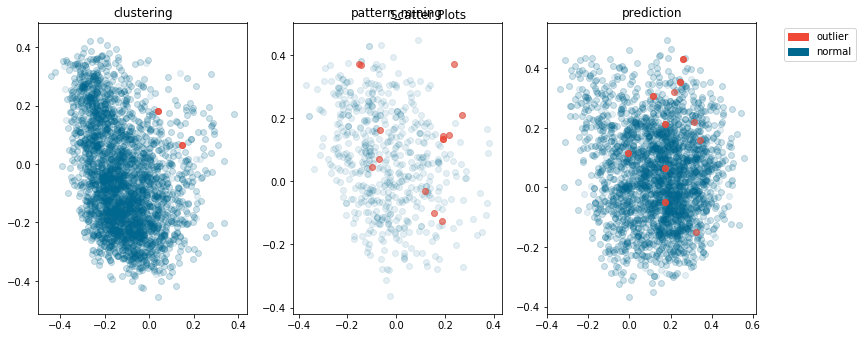

In [43]:
#%matplotlib backend
%matplotlib inline
import matplotlib.patches as mpatches

groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,9))
fig.suptitle("Scatter Plots")

ax_1 = fig.add_subplot(2,3,1)
ax_2 = fig.add_subplot(2,3,2)
ax_3 = fig.add_subplot(2,3,3)

labels = [mpatches.Patch(color="#EF4836", label="outlier"), 
          mpatches.Patch(color="#00678F", label="normal")]

axis = [ax_1, ax_2, ax_3]
for name, group in groups: 
    # Change that ax = ax_1
    axis[counter].set_title(name)
    axis[counter].scatter(group.a, group.b, color = "#00678F", alpha = 0.1)
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    legend = plt.legend(handles = labels, bbox_to_anchor=(1.5, 1.0))
    axis[counter].scatter(outlier_dataframes[name]["a"], outlier_dataframes[name]["b"], color = "#EF4836", alpha = 0.6)
    counter +=1
fig.tight_layout()

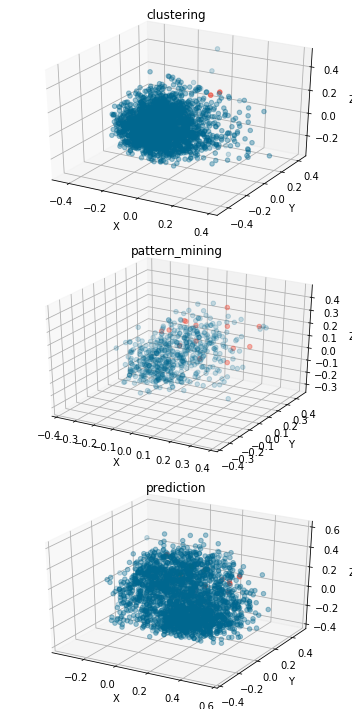

In [44]:
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (5,10))
#ax = Axes3D(fig)


for i,_class in enumerate(df_groups.keys()):
    ax = fig.add_subplot(3,1,i+1, projection = "3d")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    
    ax.set_title(_class)
    _df = df_groups[_class]
    for cluster, data in _df.groupby("cluster"):
        if cluster != -1:
            # color_from_cmap = matplotlib.cm.get_cmap("Blues")(random.uniform(0, 1))
            ax.scatter(data.x, data.y, data.z, color = "#00678F", alpha = 0.2)
        else:
            ax.scatter(data.x, data.y, data.z, color = "#EF4836", alpha = 0.4)
fig.tight_layout()

## Clustering on PCA Data

In [205]:
pd.set_option('display.max_colwidth', 0)

In [214]:
%%time
model_clustering_pca = DBSCAN(eps = 0.095, metric = "euclidean" ,min_samples = 20, n_jobs = -1)
#model_pattern_mining_pca = DBSCAN(eps = 0.15, metric = "euclidean" ,min_samples = 10, n_jobs = -1)
model_pattern_mining_pca = DBSCAN(eps = 0.11, metric = "euclidean" ,min_samples = 10, n_jobs = -1)
#model_prediction_pca = DBSCAN(eps = 0.1, metric = "euclidean" ,min_samples = 30, n_jobs = -1)
model_prediction_pca = DBSCAN(eps = 0.094, metric = "euclidean" ,min_samples = 30, n_jobs = -1)

CPU times: user 22 µs, sys: 2 µs, total: 24 µs
Wall time: 29.1 µs


In [215]:
models_pca = {"clustering":model_clustering_pca,
          "pattern_mining":model_pattern_mining_pca,
          "prediction":model_prediction_pca}

In [216]:
%%time
df_groups_pca = {}
for _class, group in df.groupby("class"): 
    x = group["x"]
    y = group["y"]
    z = group["z"]
    
    points = []
    for point in zip(x,y,z):
        points.append(point)
    
    models_pca[_class].fit(points)
    clusters = Counter(models_pca[_class].labels_)
    print("{}:{}".format(_class,clusters))
    
    _df = pd.DataFrame(group)
    _df["cluster"] = models_pca[_class].labels_
    df_groups_pca[_class] = _df

clustering:Counter({0: 5079, -1: 66})
pattern_mining:Counter({0: 551, -1: 31})
prediction:Counter({0: 4401, -1: 178})
CPU times: user 425 ms, sys: 17.1 ms, total: 442 ms
Wall time: 394 ms


In [217]:
# Prediction
x = df_groups_pca["clustering"][["class", "text", "cluster"]]
x[x["cluster"] != 0].head(10)

,class,text,cluster
4591,clustering,the degree of price clustering is high at the market opening decreases sharply for the first half hour and then settles to a stable level,-1
4600,clustering,evidence for round number effects .price clustering of individual stocks price clustering is the phenomenon that some prices are more frequently observed than others,-1
4669,clustering,although a great amount of work has been conducted on face recognition face clustering is a rather novel topic with few publications in the literature so far,-1
4690,clustering,the process is repeated until every subject is in one and the same cluster that occurs at step <unknown>,-1
4740,clustering,based on this application alone the observed findings might lead researchers to decide that it does not matter whether clustering is accounted for,-1
4745,clustering,according to their results as for the intraday pattern the degree of price clustering is maximal at the market opening and regressing during the first half hour until reaches a stable level,-1
4937,clustering,hence facial image clustering is easier than in the case of movies where actors may have unusual expressions different poses or even makeup,-1
4993,clustering,the problem with using the statistic to demonstrate clustering is that it does not reflect the geographic pattern of disease the statistic is unchanged whether all counties with more than the expected number of cases are grouped together in one geographic location or dispersed throughout the state,-1
5004,clustering,thus clustering is present only in the health coaching group and therefore there are no cluster costs in the control group,-1
5025,clustering,therefore in this study a kmeans cluster analysis is conducted to define external environment information based distinctive subdatasets for driver injury severity pattern investigation and influence estimation and also put some insights to alleviate the varied effects of risk compensation instability issue,-1


In [218]:
# Prediction
x = df_groups_pca["pattern_mining"][["class", "text", "cluster"]]
x[x["cluster"] != 0].head(10)

,class,text,cluster
9733,pattern_mining,normally association rules are applied to the problem where a and may coexist frequently e.g,-1
9736,pattern_mining,periodic pattern analysis of nonuniformly sampled stock market data intell,-1
9738,pattern_mining,consider an event or a subsequent event is frequent if its support which is the number of sequences that contian this event or subsequence is greater than a certain value,-1
9763,pattern_mining,many shopping malls have adopted sequential pattern analysis spa to find temporal associations among items but they may suffer from a higher probability of inaccurate and biased recommendations for items because they consider just purchasing information rather than rating information,-1
9798,pattern_mining,given an observed record located in this frequent pattern one intuitive thought is that the higher the ropr is the purer the frequent pattern is and the more likely the object response value will take place i.e.in our case that an accident will occur or will not happen,-1
9827,pattern_mining,given the challenge of sequential pattern mining such as inability of analyzing timing of events clark al.we hope in the future such concurrent pattern analysis will reveal an indepth look of whether the patterns are relevant e.g.students latent strategies of problemsolving or the result of unskilled mouse control,-1
9846,pattern_mining,itemsets whose support is no less than the minimum support and in the second step association rules are derived from the frequent itemsets,-1
9860,pattern_mining,work related to sequential and parallel mining class association rules are reviewed in section,-1
9874,pattern_mining,as for examples in rasheed and alhajj authors analyzed stock market data in detail and show how the periodic pattern analysis may provide the understanding of the data to predict the future trends,-1
9904,pattern_mining,three important item association rules are related with weather conditions,-1


In [219]:
# Prediction
x = df_groups_pca["prediction"][["class", "text", "cluster"]]
x[x["cluster"] != 0].head(10)

,class,text,cluster
15,prediction,third pedestrian attribute classification is a multilabel classification problem instead of a multiclass classification problem because pedestrian attributes are not completely mutually exclusive,-1
45,prediction,introduction accurate effort prediction is crucial to improve project control as well as to manage project portfolio risk,-1
62,prediction,this fact implies that the maximum possible confidence of classification is for rules in the rule base instead of,-1
75,prediction,moreover despite often being described providing information as to predictive accuracy a measure of discrimination such as the auc is entirely unaffected by whether or not a prediction is a good one,-1
93,prediction,due to the large number of possible label sets multilabel classification is rather challenging,-1
160,prediction,it indicates that the time prediction model assigns relatively high probability to the true label even if the most likely prediction is incorrect,-1
161,prediction,stock price prediction is one of the most important financial subjects attracting many traders and researchers,-1
177,prediction,given a set of items with their corresponding classes as training input classification is a type of learning which can be done in a supervised or unsupervised manner,-1
194,prediction,introduction stock market indices prediction is one of the most important and extremely challenging financial time series forecasting problems for both investors and researchers,-1
233,prediction,the classification analysis is performed using the weka tool a suite of machine learning software employed in data mining for scientific research,-1


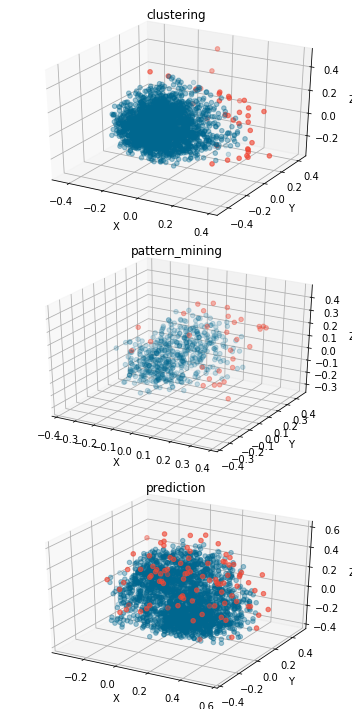

In [220]:
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (5,10))
#ax = Axes3D(fig)


for i,_class in enumerate(df_groups_pca.keys()):
    ax = fig.add_subplot(3,1,i+1, projection = "3d")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    
    ax.set_title(_class)
    _df = df_groups_pca[_class]
    for cluster, data in _df.groupby("cluster"):
        if cluster != -1:
            # color_from_cmap = matplotlib.cm.get_cmap("Blues")(random.uniform(0, 1))
            ax.scatter(data.x, data.y, data.z, color = "#00678F", alpha = 0.2)
        else:
            ax.scatter(data.x, data.y, data.z, color = "#EF4836", alpha = 0.4)
fig.tight_layout()

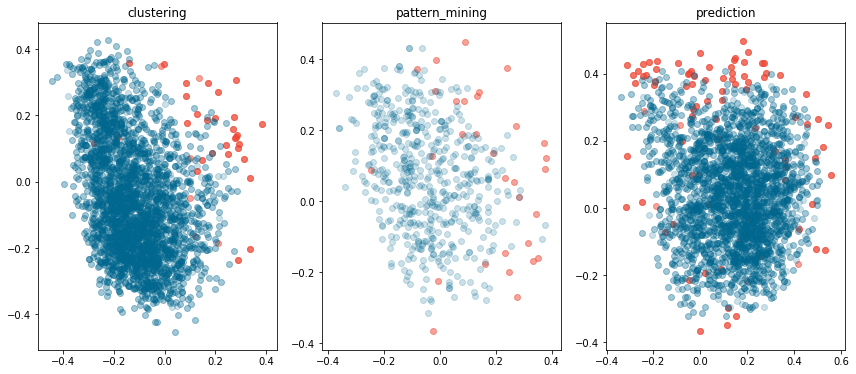

In [221]:
%matplotlib inline

fig = plt.figure(figsize=(12,10))
#fig.suptitle("Scatter Plots")


for i,_class in enumerate(df_groups_pca.keys()):
    ax = fig.add_subplot(2,3,i+1)
    ax.set_title(_class)
    _df = df_groups_pca[_class]
    for cluster, data in _df.groupby("cluster"):
        if cluster != -1:
            color_from_cmap = matplotlib.cm.get_cmap("Blues")(random.uniform(0, 1))
            ax.scatter(data.a, data.b, color = "#00678F", alpha = 0.2)
        else:
            ax.scatter(data.a, data.b, color = "#EF4836", alpha = 0.5)
fig.tight_layout()

## Creating a New Dataset

In [281]:
dst_path = "out_data"

In [282]:
df_export = pd.concat(df_groups_pca)

In [283]:
df_export.columns

Index(['url', 'text', 'class', 'embedding', 'x', 'y', 'z', 'a', 'b',
       'cluster'],
      dtype='object')

In [284]:
df_export = df_export[df_export["cluster"] != -1][["url","class"]]

In [285]:
from shutil import copyfile

In [289]:
%%time
for index,data in df_export.iterrows():
    #print(index)
    #print(data)
    file_name = str(index[1])+"_"+data["class"]+".txt"
    new_path = os.path.join(dst_path, data["class"])
    try: 
        os.makedirs(new_path)
    except FileExistsError: 
        pass
    try: 
        copyfile(data["url"], os.path.join(new_path, file_name))
    except FileExistsError: 
        print("{} is an duplicate and will not be copied twice".format(data["url"]))

CPU times: user 5.8 s, sys: 3.89 s, total: 9.69 s
Wall time: 10.3 s
